<a href="https://colab.research.google.com/github/SahanUday/Fine-Tuning-LLMs/blob/main/Fine_Tuning_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
# AutoTokenizer

# specify GPU
device = torch.device("cuda")

In [ ]:
df = pd.read_csv("spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
print(df.shape)
print(df.info())

(5572, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   int64 
 1   text    5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB
None


In [ ]:
# check class distribution
df['label'].value_counts(normalize = True)

,proportion
label,
0,0.865937
1,0.134063


In [ ]:
# train:70% test:15% validation:15%

train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

# print encoded sentences
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization


<Axes: >

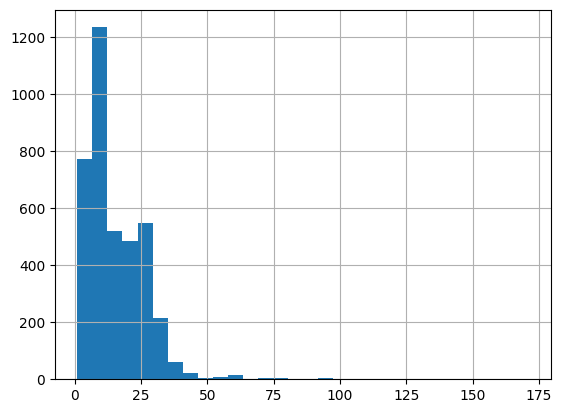

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

# Tokenize the Train test and validation dataset

In [ ]:
max_seq_len = 25

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    padding=True ,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    padding=True ,
    truncation=True,
    return_token_type_ids=False,

)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    padding=True ,
    truncation=True,
    return_token_type_ids=False
)

print(len(tokens_train['input_ids']))
print(len(tokens_val['input_ids']))
print(len(tokens_test['input_ids']))

print(list(tokens_train.keys()))
print(tokens_train['input_ids'][:2])
print(tokens_train['attention_mask'][:2])

3900
836
836
['input_ids', 'attention_mask']
[[101, 2035, 2097, 2272, 4142, 1012, 2488, 6149, 2151, 2204, 2559, 3275, 2045, 2993, 1012, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2061, 1043, 2094, 2288, 2489, 3256, 6949, 1012, 1012, 1012, 1045, 9808, 2080, 14071, 1012, 1012, 1012, 102, 0, 0, 0, 0, 0, 0]]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]]


# Convert Integer Sequences to Tensors using pytorch

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

print(f"train_seq type: {type(train_seq)}, shape: {train_seq.shape}")
print(f"train_mask type: {type(train_mask)}, shape: {train_mask.shape}")
print(f"train_y type: {type(train_y)}, shape: {train_y.shape}")

train_seq type: <class 'torch.Tensor'>, shape: torch.Size([3900, 25])
train_mask type: <class 'torch.Tensor'>, shape: torch.Size([3900, 25])
train_y type: <class 'torch.Tensor'>, shape: torch.Size([3900])


# Freeze BERT Parameters

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512, 2)

        # softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    # define the forward pass
    def forward(self, sent_id, mask):
        # pass the inputs to the model
        outputs = self.bert(sent_id, attention_mask=mask)

        # BERT returns a tuple or object with multiple outputs
        # We want the last hidden state of the [CLS] token
        if hasattr(outputs, 'last_hidden_state'):
            # Take the [CLS] token (first token) from the last hidden state
            cls_hs = outputs.last_hidden_state[:, 0, :]  # Shape: [batch_size, 768]
        elif hasattr(outputs, 'pooler_output'):
            cls_hs = outputs.pooler_output
        else:
            # Fallback: outputs is a tuple, take the first element (last_hidden_state)
            cls_hs = outputs[0][:, 0, :]  # [CLS] token from last hidden state

        # first fccl 768 -> 512
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)

        # output layer dim 512 -> 2
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

# Adam (short for Adaptive Moment Estimation)

In [ ]:
# optimizer from hugging face transformers
# from transformers.optimization import AdamW (this is depricated / use the transformers==4.20.0 instead)

# import AdamW directly from torch

# define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)

# Find Class Weights

This code block computes class weights to address the imbalance between non-spam (86.6%) and spam (13.4%) classes in the training dataset. By assigning a higher weight to the minority spam class, it ensures the model’s loss function prioritizes learning to identify spam, leading to better performance on both classes, as evidenced by the test set’s 99% accuracy and balanced F1-scores.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Updated syntax with keyword arguments
class_wts = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

print(class_wts)

[0.57743559 3.72848948]


# Negative log-likelihood loss function
Computes the negative log-likelihood loss between the model’s predicted log probabilities (output from the LogSoftmax layer in the BERT_Arch model) and the true labels (train_y or val_y).

In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function (negative log-likelihood loss function)
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10

# Fine-Tune BERT

In [ ]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []

    for step, batch in enumerate(train_dataloader):
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        model.zero_grad()

        # Use positional arguments (not keyword arguments)
        preds = model(sent_id, mask)

        # compute the training loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

# Evaluates the model on the validation dataset
to compute the validation loss and predictions without updating model parameters.

In [ ]:
def evaluate():
    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions - use positional arguments
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds


# Start Model Training

Training Loop:

- In run_training(), train() is called to train the model, followed by evaluate() to compute validation loss for each of the 10 epochs.
- The best model (lowest validation loss) is saved as saved_weights.pt.

In [ ]:
def run_training():
    # set initial loss to infinite
    best_valid_loss = float('inf')

    # empty lists to store training and validation loss of each epoch
    train_losses = []
    valid_losses = []

    # for each epoch
    for epoch in range(epochs):

        print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

        # train model
        train_loss, _ = train()

        # evaluate model
        valid_loss, _ = evaluate()

        # save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'saved_weights.pt')

        # append training and validation loss
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f'\nTraining Loss: {train_loss:.3f}')
        print(f'Validation Loss: {valid_loss:.3f}')

    return train_losses, valid_losses

In [ ]:
train_losses, valid_losses = run_training()


 Epoch 1 / 10

Evaluating...

Training Loss: 0.216
Validation Loss: 0.121

 Epoch 2 / 10

Evaluating...

Training Loss: 0.137
Validation Loss: 0.140

 Epoch 3 / 10

Evaluating...

Training Loss: 0.131
Validation Loss: 0.095

 Epoch 4 / 10

Evaluating...

Training Loss: 0.108
Validation Loss: 0.095

 Epoch 5 / 10

Evaluating...

Training Loss: 0.100
Validation Loss: 0.103

 Epoch 6 / 10

Evaluating...

Training Loss: 0.096
Validation Loss: 0.092

 Epoch 7 / 10

Evaluating...

Training Loss: 0.084
Validation Loss: 0.098

 Epoch 8 / 10

Evaluating...

Training Loss: 0.079
Validation Loss: 0.103

 Epoch 9 / 10

Evaluating...

Training Loss: 0.079
Validation Loss: 0.102

 Epoch 10 / 10

Evaluating...

Training Loss: 0.063
Validation Loss: 0.097


# Load Saved Model

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       724
           1       0.88      0.96      0.92       112

    accuracy                           0.98       836
   macro avg       0.94      0.97      0.95       836
weighted avg       0.98      0.98      0.98       836



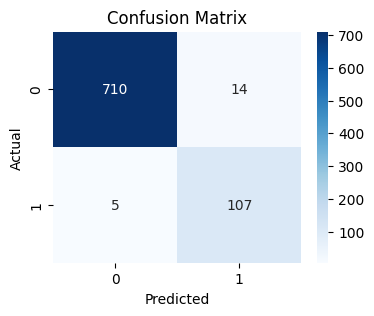

In [ ]:
# Generate the confusion matrix as a pandas DataFrame
cm = pd.crosstab(test_y, preds)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Evaluate the model on the validation set
valid_loss, valid_preds = evaluate()

# You can now analyze the results from the validation set
print(f"Validation Loss: {valid_loss:.3f}")

# Optionally, you can print a classification report or confusion matrix for the validation set
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix

# print("\nValidation Classification Report:")
# print(classification_report(val_labels, np.argmax(valid_preds, axis=1)))

# print("\nValidation Confusion Matrix:")
# print(confusion_matrix(val_labels, np.argmax(valid_preds, axis=1)))


Evaluating...
Validation Loss: 0.092


# predict on a new unseen text

In [ ]:
# Function to predict on a new unseen text
def predict_spam(text):
    # Tokenize the text
    tokens = tokenizer.batch_encode_plus(
        [text],
        max_length=max_seq_len,
        padding=True,
        truncation=True,
        return_token_type_ids=False
    )

    # Convert to tensors
    seq = torch.tensor(tokens['input_ids'])
    mask = torch.tensor(tokens['attention_mask'])

    # Move to device
    seq = seq.to(device)
    mask = mask.to(device)

    # Get prediction
    with torch.no_grad():
        preds = model(seq, mask)
        preds = preds.detach().cpu().numpy()

    # Get the predicted class (0 for not spam, 1 for spam)
    predicted_class = np.argmax(preds, axis=1)[0]

    return predicted_class



In [ ]:
# Example usage:
unseen_text = "Congratulations! You've won a free iPhone! Click here to claim your prize."
prediction = predict_spam(unseen_text)

if prediction == 1:
    print(f"The text '{unseen_text}' is predicted as SPAM.")
else:
    print(f"The text '{unseen_text}' is predicted as NOT SPAM.")

unseen_text_2 = "Hey, how are you doing today?"
prediction_2 = predict_spam(unseen_text_2)

if prediction_2 == 1:
    print(f"The text '{unseen_text_2}' is predicted as SPAM.")
else:
    print(f"The text '{unseen_text_2}' is predicted as NOT SPAM.")

The text 'Congratulations! You've won a free iPhone! Click here to claim your prize.' is predicted as SPAM.
The text 'Hey, how are you doing today?' is predicted as NOT SPAM.
